# 01 Calculate GSAT #
This notebook calculates globally averaged surface air temperature for the CDRMIP ensemble of simulations and determines the crossing period of specific global warming levels for each model simulation.

In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import pandas as pd
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/home/563/sc1326/repos/cdrmip_extremes')
from cdrmip_extremes.configs import data_dir, models, expts
from cdrmip_extremes.load_data import load_raw_tas, load_tas_anom
from cdrmip_extremes.utils import global_mean, calc_anomaly, concat_branches
from cdrmip_extremes.sat import find_crossing_years, find_matching_gwls

In [2]:
client = Client(memory_limit=None,threads_per_worker=1,n_workers=28)

### Load tas data ###

In [3]:
tas_data = load_raw_tas()

### Concatenate ramp-up and ramp-down branches ###

In [4]:
concat = {}
for model in models:
    ds_up = tas_data[model]['1pctCO2']
    ds_down = tas_data[model]['1pctCO2-cdr']
    concat[model] = concat_branches(ds_up,ds_down)

### Calculate Anomalies ###

In [5]:
anoms = {}
for model, ds in concat.items():
    anoms[model] = calc_anomaly(ds,tas_data[model]['piControl'],slice(None,None))

In [6]:
# save
save_dir = os.path.join(data_dir,'processed/tas/anomalies')
for model, ds in anoms.items():
    path = os.path.join(
        save_dir,
        f"{model}_cdr-reversibility_tas_anom.nc"
    )
    # ds.to_netcdf(path)

### Calculate GSAT ###

In [7]:
gsat = {}
for model, ds in anoms.items():
    gsat[model] = global_mean(ds).rename('gsat')

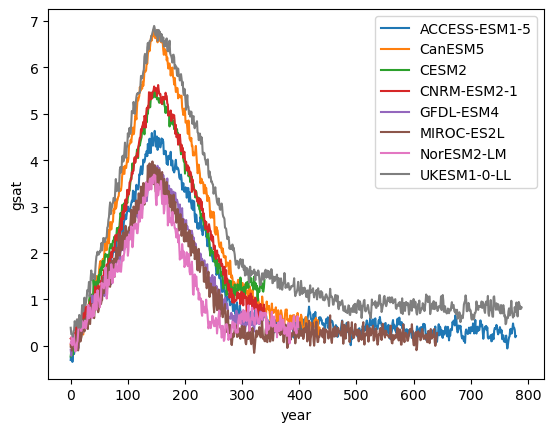

In [8]:
for model, ds in gsat.items():
    ds.groupby('time.year').mean(dim='time').plot(label=model)
plt.legend()

In [9]:
# save gsat
save_dir = os.path.join(data_dir,'processed/gsat')
for model, ds in gsat.items():
    path = os.path.join(
        save_dir,
        f"{model}_cdr-reversibility_gsat.nc"
    )
    # ds.to_netcdf(path)

## Determine GWL crossing times ##

In [10]:
gwl_years = {}
for model, da in gsat.items():
    gwl_years[model] = find_crossing_years(
        da,
        window=21,
        gwls=[1.5,2.0,3.0],
        time_dim='time',
        overshoot=True
    )

In [11]:
# save
save_dir = os.path.join(
    data_dir,"processed/gwl_years"
)
for model, da in gwl_years.items():
    path = os.path.join(
        save_dir,
        f"{model}_gwl_years.nc"
    )
    # da.to_netcdf(path)

### Determine period where GWL matches end GWL (final 21-years) ###

In [12]:
matching_gwls = {}
for model, da in gsat.items():
    matching_gwls[model] = find_matching_gwls(da,21,slice(320,340),time_dim='time')
matching_gwls

{'ACCESS-ESM1-5': [0.64, 30],
 'CanESM5': [0.9, 34],
 'CESM2': [1.27, 45],
 'CNRM-ESM2-1': [0.81, 31],
 'GFDL-ESM4': [0.55, 29],
 'MIROC-ES2L': [0.23, 17],
 'NorESM2-LM': [0.6, 30],
 'UKESM1-0-LL': [1.51, 39]}

In [13]:
df = pd.DataFrame.from_dict(matching_gwls, orient='index', columns=['tas', 'year'])
match_ds = xr.Dataset.from_dataframe(df).rename({'index':'model'})

In [14]:
# save
path = os.path.join(data_dir,"processed/revised_gwl/matched_gwls.nc")
# match_ds.to_netcdf(path)